In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import *
from prepare_data import *
from datetime import datetime
from tensorflow.keras.applications.inception_v3 import preprocess_input
import albumentations as A
import matplotlib.pyplot as plt
import random

In [13]:
dataset = Dataset.ninety
extractor_train, extractor_val = prep_data_single(dataset, 8)

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.ToGray(p=0.3),
    A.Blur(p=0.3)
])

train_gen, val_gen = prep_data_augmented(dataset, extractor_train, extractor_val, 8, 6, augment=augment)

Found 5400 files belonging to 90 classes.
Using 4590 files for training.
Found 5400 files belonging to 90 classes.
Using 810 files for validation.


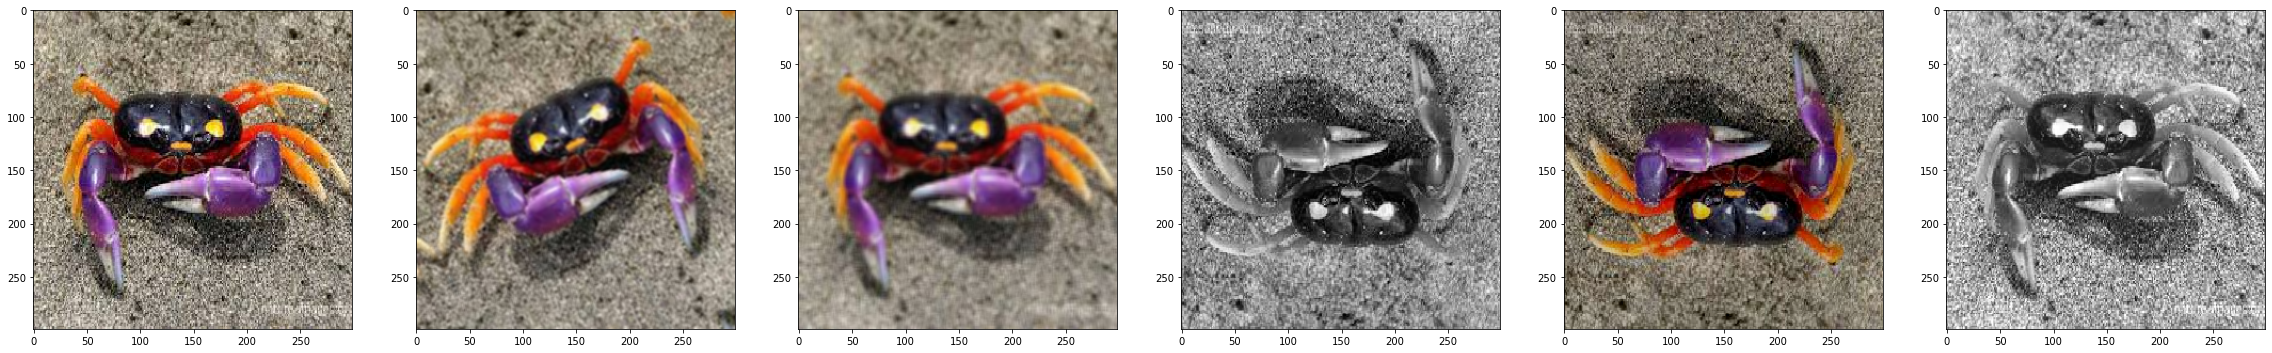

In [16]:
fig, ax = plt.subplots(1, train_gen.inputsize)
i = random.randint(0, len(train_gen))
imgs = train_gen.__getitem__(i)[0][0]
fig.set_size_inches(40, 40)

for i, im in enumerate(imgs):
    ax[i].imshow(im)

In [ ]:
dataset = Dataset.carabid
_, val_dataset = prep_data_single(dataset, 1)


extractor_model_path = "models/carabid/CARABID-EXTRACTOR/extractor/savefile.hdf5"
extractor_model = keras.models.load_model(extractor_model_path)

augs = {"no augs": None,
        "horizontal flip": A.Compose([A.HorizontalFlip(p=1.0)]),
        "vertical flip": A.Compose([A.VerticalFlip(p=1.0)]),
        "rotate": A.Compose([A.Rotate(p=1.0)]),
        "brightness/contrast": A.Compose([A.RandomBrightnessContrast(p=1.0)]),
        "gamma": A.Compose([A.RandomGamma(p=1.0)]),
        "grey": A.Compose([A.ToGray(p=1.0)]),
        "blur": A.Compose([A.Blur(p=1.0)])}

In [ ]:
accuracy_test_model = keras.Sequential([extractor_model.layers[0].layers[-1], extractor_model.layers[-1]])
accuracy_test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
augs = {"no augs": None,
        "all augs": A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(p=0.5),
                A.RandomBrightnessContrast(p=1.0),
                A.RandomGamma(p=0.5),
                A.ToGray(p=0.3),
                A.Blur(p=0.3)]),
        "no bad augs": A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(p=0.5),
                A.RandomBrightnessContrast(p=1.0),
                A.RandomGamma(p=0.5)])}

multi_aug_results = {}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    multi_aug_results[name] = accuracy_test_model.evaluate(extractor_val)

print(multi_aug_results)

In [ ]:
feature_output_tester = keras.Sequential([accuracy_test_model.layers[0]])
feature_output_tester.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

feature_outputs = {}
generators = {}
for name, aug in augs.items():
    generators[name] = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)[1]
    feature_outputs[name] = np.zeros(1000)

for i in range(len(generators["no augs"])):
    img, _ = generators["no augs"].__getitem__(i)
    ground_truth = feature_output_tester.predict(img)[0]

    for name, generator in generators.items():
        if name == "no augs":
            continue

        img, _ = generator.__getitem__(i)
        features = feature_output_tester.predict(img)[0]
        feature_outputs[name] += np.abs(ground_truth - features)

length = len(generators["no augs"])
for name, result in feature_outputs.items():
    print(f"{name}: {sum(result / length)}")

In [ ]:
features_model = keras.Sequential([extractor_model.layers[0].layers[-1]])
features_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
feature_outputs = {}
generators = {}
for name, aug in augs.items():
    generators[name] = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)[1]
    feature_outputs[name] = np.zeros(1000)

for i in range(len(generators["no augs"])):
    img, _ = generators["no augs"].__getitem__(i)
    ground_truth = features_model.predict(img)[0]

    for name, generator in generators.items():
        if name == "no augs":
            continue

        img, _ = generator.__getitem__(i)
        features = features_model.predict(img)[0]
        feature_outputs[name] += np.abs(ground_truth - features)

print(feature_outputs)
length = len(generators["no augs"])
for name, result in feature_outputs.items():
    print(f"{name}: {sum(result / length)}")

In [ ]:
feature_outputs2 = {}
generators = {}

augs = {"no augs": None,
        "horizontal flip - vertical flip": A.Compose([A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0)]),
        "horizontal flip - rotate": A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(p=1.0)]),
        "horizontal flip - brightness/contrast": A.Compose([A.HorizontalFlip(p=1.0), A.RandomBrightnessContrast(p=1.0)]),
        "horizontal flip - gamma": A.Compose([A.HorizontalFlip(p=1.0), A.RandomGamma(p=1.0)]),
        "horizontal flip - grey": A.Compose([A.HorizontalFlip(p=1.0), A.ToGray(p=1.0)]),
        "horizontal flip - blur": A.Compose([A.HorizontalFlip(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    generators[name] = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)[1]
    feature_outputs2[name] = np.zeros(1000)

for i in range(len(generators["no augs"])):
    img, _ = generators["no augs"].__getitem__(i)
    ground_truth = features_model.predict(img)[0]

    for name, generator in generators.items():
        if name == "no augs":
            continue

        img, _ = generator.__getitem__(i)
        features = features_model.predict(img)[0]
        feature_outputs2[name] += np.abs(ground_truth - features)

print(feature_outputs2)
length = len(generators["no augs"])
for name, result in feature_outputs2.items():
    print(f"{name}: {sum(result / length)}")

In [ ]:
aug_results = {}
augs = {"no augs": None,
        "horizontal flip": A.Compose([A.HorizontalFlip(p=1.0)]),
        "vertical flip": A.Compose([A.VerticalFlip(p=1.0)]),
        "rotate": A.Compose([A.Rotate(p=1.0)]),
        "brightness/contrast": A.Compose([A.RandomBrightnessContrast(p=1.0)]),
        "gamma": A.Compose([A.RandomGamma(p=1.0)]),
        "grey": A.Compose([A.ToGray(p=1.0)]),
        "blur": A.Compose([A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    aug_results[name] = extractor_model.evaluate(extractor_val)

print(aug_results)

In [ ]:
two_img_2aug_hori_results = {}
augs = {"no augs": None,
        "horizontal flip - vertical flip": A.Compose([A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0)]),
        "horizontal flip - rotate": A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(p=1.0)]),
        "horizontal flip - brightness/contrast": A.Compose([A.HorizontalFlip(p=1.0), A.RandomBrightnessContrast(p=1.0)]),
        "horizontal flip - gamma": A.Compose([A.HorizontalFlip(p=1.0), A.RandomGamma(p=1.0)]),
        "horizontal flip - grey": A.Compose([A.HorizontalFlip(p=1.0), A.ToGray(p=1.0)]),
        "horizontal flip - blur": A.Compose([A.HorizontalFlip(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    two_img_2aug_hori_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_hori_results)

In [ ]:
two_img_2aug_gamma_results = {}
augs = {"no augs": None,
        "gamma - vertical flip": A.Compose([A.RandomGamma(p=1.0), A.VerticalFlip(p=1.0)]),
        "gamma - rotate": A.Compose([A.RandomGamma(p=1.0), A.Rotate(p=1.0)]),
        "gamma - brightness/contrast": A.Compose([A.RandomGamma(p=1.0), A.RandomBrightnessContrast(p=1.0)]),
        "gamma - horizontal flip": A.Compose([A.RandomGamma(p=1.0), A.HorizontalFlip(p=1.0)]),
        "gamma - grey": A.Compose([A.RandomGamma(p=1.0), A.ToGray(p=1.0)]),
        "gamma - blur": A.Compose([A.RandomGamma(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    two_img_2aug_gamma_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_gamma_results)

In [ ]:
two_img_2aug_bricon_results = {}
augs = {"no augs": None,
        "brightness/contrast - vertical flip": A.Compose([A.RandomBrightnessContrast(p=1.0), A.VerticalFlip(p=1.0)]),
        "brightness/contrast - rotate": A.Compose([A.RandomBrightnessContrast(p=1.0), A.Rotate(p=1.0)]),
        "brightness/contrast - horizontal flip": A.Compose([A.RandomBrightnessContrast(p=1.0), A.HorizontalFlip(p=1.0)]),
        "brightness/contrast - gamma": A.Compose([A.RandomBrightnessContrast(p=1.0), A.RandomGamma(p=1.0)]),
        "brightness/contrast - grey": A.Compose([A.RandomBrightnessContrast(p=1.0), A.ToGray(p=1.0)]),
        "brightness/contrast - blur": A.Compose([A.RandomBrightnessContrast(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_aug_single(dataset, val_dataset, val_dataset, 1, augment=aug)
    two_img_2aug_bricon_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_bricon_results)

In [ ]:
two_img_aug_results = {}
extractor_model = keras.models.load_model("models/carabid/CARABID-2-CLASSIFIER/classifier/savefile.hdf5")
for name, aug in augs.items():
    _, extractor_val = prep_data_augmented(dataset, val_dataset, val_dataset, 1, 2, augment=aug)
    two_img_aug_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_aug_results)

In [ ]:
two_img_2aug_hori_results = {}
augs = {"no augs": None,
        "horizontal flip - vertical flip": A.Compose([A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0)]),
        "horizontal flip - rotate": A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(p=1.0)]),
        "horizontal flip - brightness/contrast": A.Compose([A.HorizontalFlip(p=1.0), A.RandomBrightnessContrast(p=1.0)]),
        "horizontal flip - gamma": A.Compose([A.HorizontalFlip(p=1.0), A.RandomGamma(p=1.0)]),
        "horizontal flip - grey": A.Compose([A.HorizontalFlip(p=1.0), A.ToGray(p=1.0)]),
        "horizontal flip - blur": A.Compose([A.HorizontalFlip(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_augmented(dataset, val_dataset, val_dataset, 1, 2, augment=aug)
    two_img_2aug_hori_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_hori_results)

In [ ]:
two_img_2aug_gamma_results = {}
augs = {"no augs": None,
        "gamma - vertical flip": A.Compose([A.RandomGamma(p=1.0), A.VerticalFlip(p=1.0)]),
        "gamma - rotate": A.Compose([A.RandomGamma(p=1.0), A.Rotate(p=1.0)]),
        "gamma - brightness/contrast": A.Compose([A.RandomGamma(p=1.0), A.RandomBrightnessContrast(p=1.0)]),
        "gamma - horizontal flip": A.Compose([A.RandomGamma(p=1.0), A.HorizontalFlip(p=1.0)]),
        "gamma - grey": A.Compose([A.RandomGamma(p=1.0), A.ToGray(p=1.0)]),
        "gamma - blur": A.Compose([A.RandomGamma(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_augmented(dataset, val_dataset, val_dataset, 1, 2, augment=aug)
    two_img_2aug_gamma_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_gamma_results)

In [ ]:
two_img_2aug_bricon_results = {}
augs = {"no augs": None,
        "brightness/contrast - vertical flip": A.Compose([A.RandomBrightnessContrast(p=1.0), A.VerticalFlip(p=1.0)]),
        "brightness/contrast - rotate": A.Compose([A.RandomBrightnessContrast(p=1.0), A.Rotate(p=1.0)]),
        "brightness/contrast - horizontal flip": A.Compose([A.RandomBrightnessContrast(p=1.0), A.HorizontalFlip(p=1.0)]),
        "brightness/contrast - gamma": A.Compose([A.RandomBrightnessContrast(p=1.0), A.RandomGamma(p=1.0)]),
        "brightness/contrast - grey": A.Compose([A.RandomBrightnessContrast(p=1.0), A.ToGray(p=1.0)]),
        "brightness/contrast - blur": A.Compose([A.RandomBrightnessContrast(p=1.0), A.Blur(p=1.0)])}
for name, aug in augs.items():
    _, extractor_val = prep_data_augmented(dataset, val_dataset, val_dataset, 1, 2, augment=aug)
    two_img_2aug_bricon_results[name] = extractor_model.evaluate(extractor_val)

print(two_img_2aug_bricon_results)